In [2]:
!pip install transformers==4.57.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.4.0
    Uninstalling huggingface_hub-1.4.0:
      Successfully uninstalled huggingface_hub-1.4.0
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0


In [3]:
!git clone https://github.com/AlessandroMaini/CucumBERT_askqe.git -b answerability-check

Cloning into 'CucumBERT_askqe'...
remote: Enumerating objects: 2472, done.
remote: Counting objects: 100% (499/499), done.
remote: Compressing objects: 100% (274/274), done.
remote: Total 2472 (delta 307), reused 384 (delta 218), pack-reused 1973 (from 1)
Receiving objects: 100% (2472/2472), 63.59 MiB | 12.24 MiB/s, done.
Resolving deltas: 100% (1738/1738), done.


# Answerability-Check Pipeline: An Extension of AskQE

The Vanilla QG pipeline in AskQE directly prompts an LLM to generate questions from the source sentence. Without the contextual grounding of the NLI pipeline's fact-extraction step, it is prone to **hallucinated questions** — questions not answerable from the source.

**Our proposal**: add a lightweight **answerability-check filter** after Vanilla QG to discard unanswerable questions before the Answering step.

In [4]:
import json, warnings, torch, numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib.ticker as mticker, seaborn as sns
from pathlib import Path
from ast import literal_eval
from IPython.display import display
from transformers import LongformerTokenizer, LongformerForSequenceClassification

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.05)

BASE = Path('CucumBERT_askqe')
THRESHOLD = 0.90
PERTURBATIONS = ['synonym', 'alteration', 'omission', 'expansion_noimpact']
MINOR = {'synonym', 'expansion_noimpact'}

# ── Helpers ────────────────────────────────────────────────
def load_jsonl(path):
    rows = []
    for line in open(path, encoding='utf-8'):
        rec = json.loads(line)
        for f in ('questions', 'answers'):
            if isinstance(rec.get(f), str):
                try: rec[f] = json.loads(rec[f])
                except Exception: rec[f] = []
        rows.append(rec)
    return pd.DataFrame(rows)

def load_results(subdir):
    return {lp: json.load(open(BASE / f'evaluation/{subdir}/results_{lp}.json'))
            for lp in ('en-es', 'en-fr')}

# ── Load question sets ─────────────────────────────────────
pipelines = {
    'Vanilla':             load_jsonl(BASE / 'QG/qwen3-4b/questions-vanilla.jsonl'),
    'AnsCheck-Longformer': load_jsonl(BASE / 'QG/qwen3-4b/questions-anscheck-longformer.jsonl'),
    'AnsCheck-ELECTRA':    load_jsonl(BASE / 'QG/qwen3-4b/questions-anscheck-electra.jsonl'),
}
for df in pipelines.values():
    df['n_qs'] = df['questions'].apply(len)

print("Setup complete.")

Setup complete.


## 1. The Problem: Vanilla Questions Are Not Always Answerable

We score every question with the **Longformer answerability classifier** (`potsawee/longformer-large-4096-answerable-squad2`). A score ≥ 0.90 means answerable.

In [5]:
# ── Load Longformer answerability model ─────────────────────
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "potsawee/longformer-large-4096-answerable-squad2"
tokenizer = LongformerTokenizer.from_pretrained(model_name)
model = LongformerForSequenceClassification.from_pretrained(model_name).to(DEVICE).eval()
print(f"Longformer loaded on {DEVICE}")

# ── Score every question in all three pipelines ────────────
def score_pipeline(df):
    all_scores = []
    for _, row in df.iterrows():
        ctx = row['en']
        q_scores = []
        for q in (row['questions'] if isinstance(row['questions'], list) else []):
            inp = tokenizer(q + ' ' + tokenizer.sep_token + ' ' + ctx,
                            max_length=4096, truncation=True, return_tensors="pt").to(DEVICE)
            with torch.no_grad():
                q_scores.append(torch.sigmoid(model(**inp).logits.squeeze(-1)).item())
        all_scores.append(q_scores)
    return all_scores

for name, df in pipelines.items():
    print(f"Scoring {name} ({df['n_qs'].sum()} Qs)…")
    df['ans_scores'] = score_pipeline(df)
    df['avg_answerability'] = df['ans_scores'].apply(lambda s: np.mean(s) if s else np.nan)
    df['frac_answerable'] = df['ans_scores'].apply(
        lambda s: np.mean([x >= THRESHOLD for x in s]) if s else 1.0)
print("Done.")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

Initializing global attention on CLS token...
Input ids are automatically padded to be a multiple of `config.attention_window`: 512


Longformer loaded on cuda
Scoring Vanilla (2244 Qs)…
Scoring AnsCheck-Longformer (1758 Qs)…
Scoring AnsCheck-ELECTRA (1736 Qs)…
Done.


═══ Vanilla Pipeline — Answerability Statistics ═══
  Total questions:           2244
  Avg Qs / sentence:         4.49
  Avg answerability score:   0.8982
  Answerable (≥ 0.9):      1758  (78.3%)
  Unanswerable (< 0.9):    486  (21.7%)


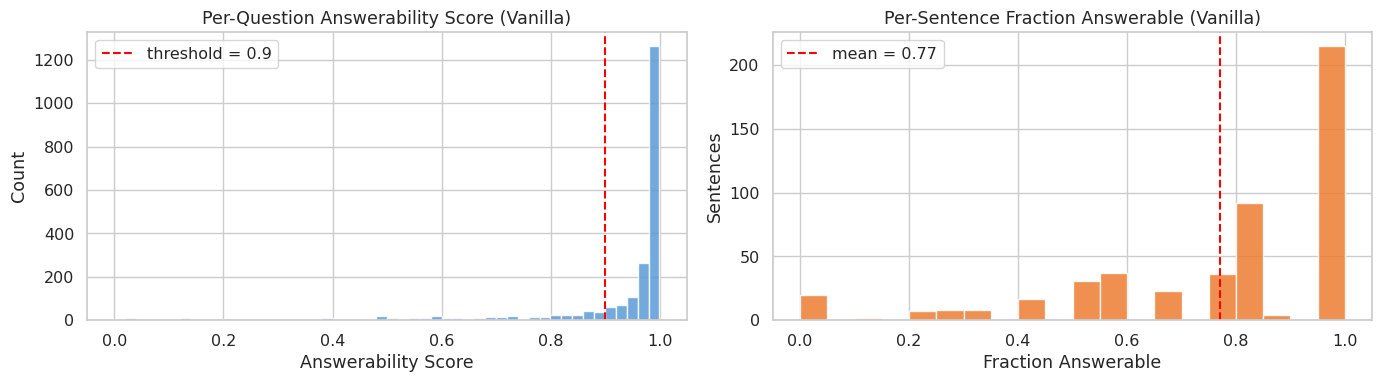


═══ Unanswerable Question Examples ═══

  Source: "and are you having any of the following symptoms with your chest pain"
    ❌ [0.891]  "What symptoms should be considered with chest pain?"
    ✅ [0.927]  "What symptoms are associated with chest pain?"
    ✅ [0.976]  "Are any specific symptoms mentioned with chest pain?"

  Source: "and drink lots of fluids"
    ❌ [0.434]  "What should you do when you are ill?"
    ❌ [0.493]  "Why is it important to drink lots of fluids?"
    ✅ [0.905]  "What is the benefit of drinking lots of fluids?"
    ✅ [0.936]  "What does 'drink lots of fluids' suggest in the context of illness?"

  Source: "are you having any difficulty breathing now"
    ❌ [0.500]  "Are you having any difficulty breathing now?"

  Source: "but if you have the cough"
    ❌ [0.306]  "What does 'if you have the cough' imply?"
    ❌ [0.173]  "What condition is associated with having a cough?"
    ❌ [0.885]  "What might be the cause of a cough in this context?"

  Source: "cause t

In [24]:
# ── Vanilla answerability stats ─────────────────────────────
dv = pipelines['Vanilla']
flat = [s for row in dv['ans_scores'] for s in row]
n_unans = sum(s < THRESHOLD for s in flat)

print("═══ Vanilla Pipeline — Answerability Statistics ═══")
print(f"  Total questions:           {len(flat)}")
print(f"  Avg Qs / sentence:         {dv['n_qs'].mean():.2f}")
print(f"  Avg answerability score:   {np.mean(flat):.4f}")
print(f"  Answerable (≥ {THRESHOLD}):      {len(flat)-n_unans}  ({1-n_unans/len(flat):.1%})")
print(f"  Unanswerable (< {THRESHOLD}):    {n_unans}  ({n_unans/len(flat):.1%})")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(flat, bins=50, color='#5b9bd5', edgecolor='white', alpha=.85)
axes[0].axvline(THRESHOLD, color='red', ls='--', lw=1.5, label=f'threshold = {THRESHOLD}')
axes[0].set(xlabel='Answerability Score', ylabel='Count',
            title='Per-Question Answerability Score (Vanilla)')
axes[0].legend()
axes[1].hist(dv['frac_answerable'], bins=20, color='#ed7d31', edgecolor='white', alpha=.85)
axes[1].axvline(dv['frac_answerable'].mean(), color='red', ls='--', lw=1.5,
                label=f"mean = {dv['frac_answerable'].mean():.2f}")
axes[1].set(xlabel='Fraction Answerable', ylabel='Sentences',
            title='Per-Sentence Fraction Answerable (Vanilla)')
axes[1].legend()
plt.tight_layout(); plt.show()

# ── Examples of unanswerable questions ─────────────────────
print("\n═══ Unanswerable Question Examples ═══\n")
shown = 0
for _, row in dv.iterrows():
    if shown >= 5: break
    bad = [(q, s) for q, s in zip(row['questions'], row['ans_scores']) if s < THRESHOLD]
    good = [(q, s) for q, s in zip(row['questions'], row['ans_scores']) if s >= THRESHOLD]
    if not bad: continue
    print(f'  Source: "{row["en"]}"')
    for q, s in bad:  print(f'    ❌ [{s:.3f}]  "{q}"')
    for q, s in good[:2]: print(f'    ✅ [{s:.3f}]  "{q}"')
    print(); shown += 1

## 2. Proposed Solution: Answerability-Check Filter

We add a **post-QG filter** that discards questions scoring below 0.90. Two filter models are compared:

| Filter Model | Type |
|---|---|
| `potsawee/longformer-large-4096-answerable-squad2` | Sequence classification |
| `deepset/electra-base-squad2` | Extractive QA (null-score calibration) |

Both pipelines remove ~22% of questions. Answerability is always **scored by Longformer**, which explains the dramatic gap between the two filtered pipelines: AnsCheck-Longformer reaches 100% answerable by construction (same model filters and evaluates), while AnsCheck-ELECTRA — filtered by an independent model — shows a more realistic 85%.

Pipeline,Sentences,Total Qs,Avg Qs/Sent,Avg Answerability,Frac ≥ 0.90,Reduction
Vanilla,500,2244,4.49,0.8982,78.3%,—
AnsCheck-Longformer,480,1758,3.66,0.9809,100.0%,21.7%
AnsCheck-ELECTRA,473,1736,3.67,0.9293,85.0%,22.6%


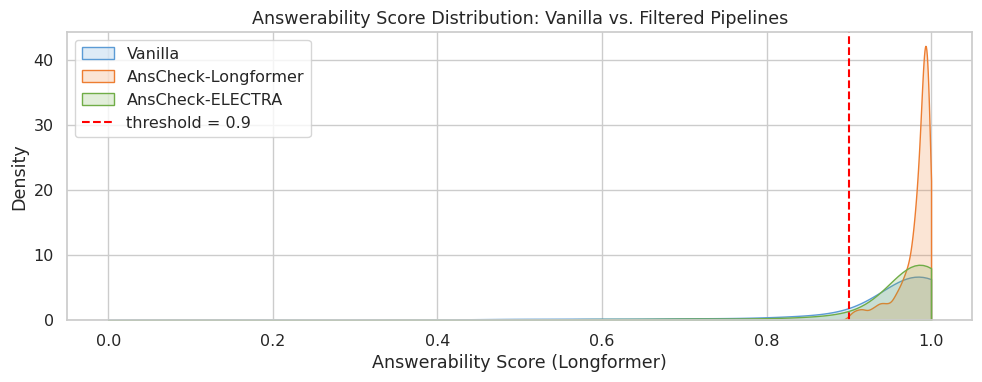

In [10]:
# ── Summary table ──────────────────────────────────────────
total_v = pipelines['Vanilla']['n_qs'].sum()
rows = []
for name, df in pipelines.items():
    flat = [s for row in df['ans_scores'] for s in row]
    total = df['n_qs'].sum()
    rows.append({
        'Pipeline': name, 'Sentences': len(df), 'Total Qs': total,
        'Avg Qs/Sent': f"{df['n_qs'].mean():.2f}",
        'Avg Answerability': f"{np.mean(flat):.4f}",
        'Frac ≥ 0.90': f"{np.mean([s>=THRESHOLD for s in flat]):.1%}",
        'Reduction': f"{(1-total/total_v)*100:.1f}%" if name != 'Vanilla' else '—',
    })
display(pd.DataFrame(rows).style.hide(axis='index').set_caption(
    'Comparison: Question Volume & Answerability (scored by Longformer)'))

# ── KDE of answerability score distributions ───────────────
fig, ax = plt.subplots(figsize=(10, 4))
colors = {'Vanilla': '#5b9bd5', 'AnsCheck-Longformer': '#ed7d31', 'AnsCheck-ELECTRA': '#70ad47'}
for name, df in pipelines.items():
    flat = [s for row in df['ans_scores'] for s in row]
    sns.kdeplot(flat, label=name, fill=True, alpha=.2, color=colors[name], ax=ax, clip=(0,1))
ax.axvline(THRESHOLD, color='red', ls='--', lw=1.5, label=f'threshold = {THRESHOLD}')
ax.set(xlabel='Answerability Score (Longformer)', ylabel='Density',
       title='Answerability Score Distribution: Vanilla vs. Filtered Pipelines')
ax.legend(); plt.tight_layout(); plt.show()

## 3. Extension Evaluation

We evaluate whether the filter improves AskQE's ability to assess translation quality on two axes:

1. **Instance-level Pearson correlation** between AskQE metrics and standard MT metrics (xCOMET, BT-Score).
2. **Silhouette score** — how well AskQE metrics separate **critical** (omission, alteration) from **minor** (synonym, expansion) perturbations.

### 3.1 Instance-Level Pearson Correlation

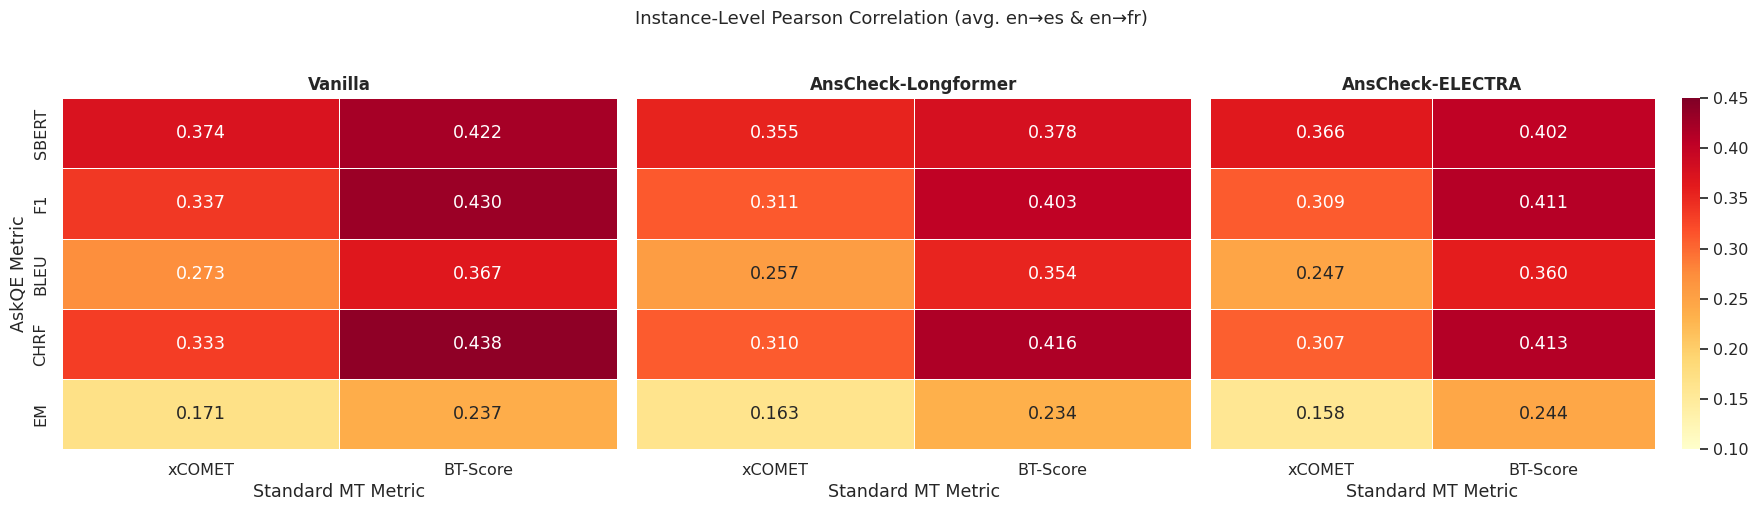

In [11]:
# ── Pearson heatmaps (pre-computed) ────────────────────────
pearson = load_results('pearson-correlation')
PIPE_MAP = {'vanilla': 'Vanilla', 'anscheck-longformer': 'AnsCheck-Longformer',
            'anscheck-electra': 'AnsCheck-ELECTRA'}
AQ = ['sbert', 'f1', 'bleu', 'chrf', 'em']

heatmaps = {}
for pk, pl in PIPE_MAP.items():
    mat = {}
    for aq in AQ:
        mk = f"{aq}-{pk}"
        for sm in ('xcomet', 'bt_score'):
            vals = [c['pearson_r'] for lp in pearson.values()
                    for c in lp['correlations']
                    if c['askqe_metric'] == mk and c['standard_metric'] == sm]
            mat.setdefault(aq.upper(), {})[sm] = np.mean(vals) if vals else np.nan
    heatmaps[pl] = pd.DataFrame(mat).T
    heatmaps[pl].columns = ['xCOMET', 'BT-Score']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for ax, (pl, df_hm) in zip(axes, heatmaps.items()):
    sns.heatmap(df_hm, annot=True, fmt='.3f', cmap='YlOrRd', vmin=0.1, vmax=0.45,
                linewidths=.5, ax=ax, cbar=pl == 'AnsCheck-ELECTRA')
    ax.set_title(pl, fontsize=12, fontweight='bold')
    ax.set_ylabel('AskQE Metric' if ax == axes[0] else '')
    ax.set_xlabel('Standard MT Metric')
plt.suptitle('Instance-Level Pearson Correlation (avg. en→es & en→fr)', fontsize=13, y=1.02)
plt.tight_layout(); plt.show()

### 3.2 Silhouette Score (Error-Type Separation)

Higher silhouette = clearer separation between **critical** (omission, alteration) and **minor** (synonym, expansion) perturbations. Oracle MT metrics (xCOMET, BERTScore) serve as upper bounds.

Pipeline,Vanilla,AnsCheck-Longformer,AnsCheck-ELECTRA,Oracle (bertscore),Oracle (xcomet)
Metric,,,,,
BLEU,0.0350,0.0351,0.0344,—,—
CHRF,0.0560,0.0561,0.0593,—,—
EM,0.0205,0.0195,0.0189,—,—
F1,0.0506,0.0500,0.0489,—,—
SBERT,0.0673,0.0628,0.0646,—,—
BERTSCORE,—,—,—,0.1014,—
XCOMET,—,—,—,—,0.2133


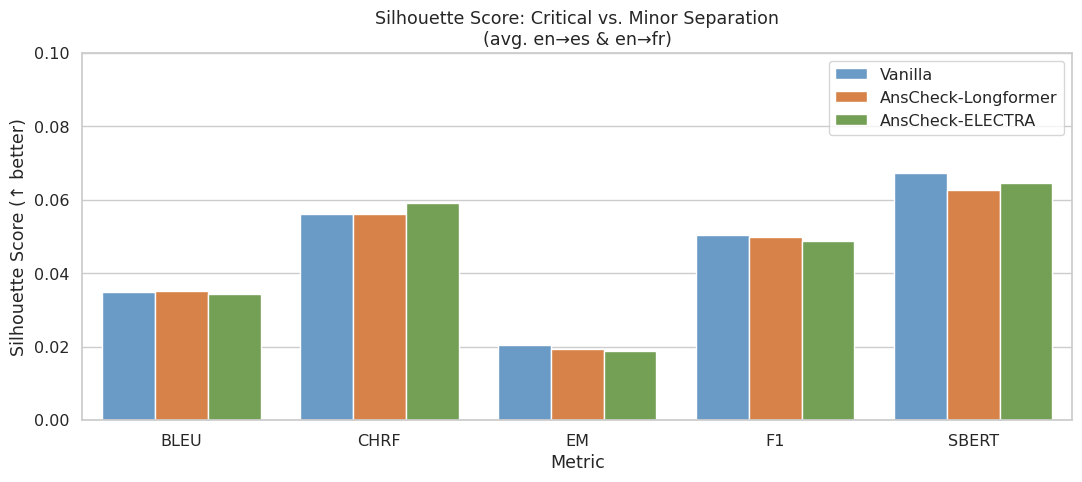

In [12]:
# ── Silhouette scores (pre-computed) ───────────────────────
silhouette = load_results('silhouette')
PIPE_SIL = {('vanilla', None): 'Vanilla',
            ('anscheck', 'longformer'): 'AnsCheck-Longformer',
            ('anscheck', 'electra'): 'AnsCheck-ELECTRA'}

sil_rows = []
for lp, data in silhouette.items():
    for mt, v in data['mt_results'].items():
        sil_rows.append(dict(Lang=lp, Pipeline=f'Oracle ({mt})', Metric=mt.upper(),
                             Silhouette=v['silhouette_score']))
    for p in data['results']:
        label = PIPE_SIL.get((p['pipeline'], p.get('anscheck_type')))
        if label:
            for m, v in p['metrics'].items():
                sil_rows.append(dict(Lang=lp, Pipeline=label, Metric=m.upper(),
                                     Silhouette=v['silhouette_score']))

df_sil = pd.DataFrame(sil_rows)
askqe = df_sil[df_sil['Pipeline'].isin(PIPE_SIL.values())]
tbl = askqe.groupby(['Metric','Pipeline'])['Silhouette'].mean().unstack('Pipeline')
tbl = tbl[['Vanilla','AnsCheck-Longformer','AnsCheck-ELECTRA']]
oracle = df_sil[df_sil['Pipeline'].str.startswith('Oracle')].groupby(
    ['Metric','Pipeline'])['Silhouette'].mean().unstack('Pipeline')
display(pd.concat([tbl, oracle], axis=1).style.format('{:.4f}', na_rep='—').set_caption(
    'Silhouette Scores (avg. en→es & en→fr) — Higher is better'))

# ── Grouped bar plot ───────────────────────────────────────
plot = askqe.groupby(['Metric','Pipeline'])['Silhouette'].mean().reset_index()
fig, ax = plt.subplots(figsize=(11, 5))
sns.barplot(data=plot, x='Metric', y='Silhouette', hue='Pipeline',
            hue_order=['Vanilla','AnsCheck-Longformer','AnsCheck-ELECTRA'],
            palette={'Vanilla':'#5b9bd5','AnsCheck-Longformer':'#ed7d31','AnsCheck-ELECTRA':'#70ad47'}, ax=ax)
ax.set(title='Silhouette Score: Critical vs. Minor Separation\n(avg. en→es & en→fr)',
       ylabel='Silhouette Score (↑ better)', ylim=(0, 0.10))
ax.legend(title='', loc='upper right')
plt.tight_layout(); plt.show()

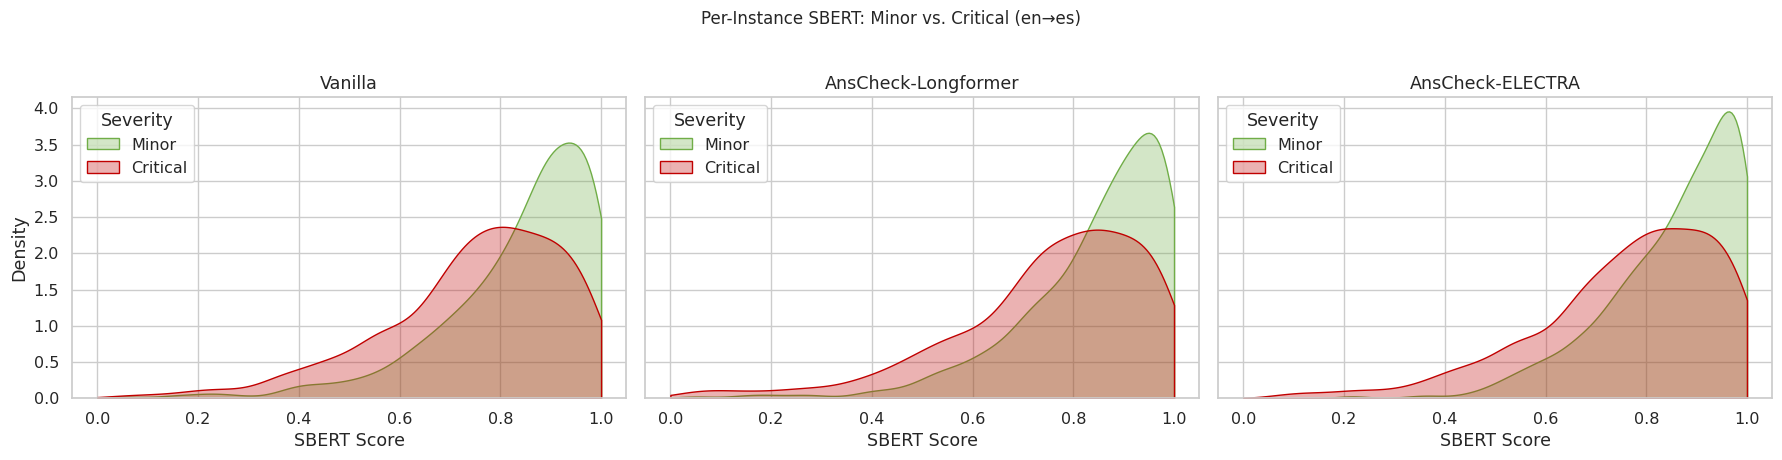

In [13]:
# ── KDE: per-instance SBERT, Minor vs Critical (pre-computed) ─
SBERT_DIR = {'vanilla': 'vanilla', 'anscheck-longformer': 'anscheck',
             'anscheck-electra': 'anscheck'}

def sbert_fname(pipe_key, pert):
    if 'anscheck' in pipe_key:
        return f"{pipe_key.split('-',1)[1]}-{pert}.jsonl"
    return f"{pert}.jsonl"

kde_rows = []
for pk, pl in PIPE_MAP.items():
    base = BASE / f'evaluation/sbert/en-es/{SBERT_DIR[pk]}'
    for pert in PERTURBATIONS:
        path = base / sbert_fname(pk, pert)
        if not path.exists(): continue
        for line in open(path, encoding='utf-8'):
            rec = json.loads(line)
            kde_rows.append(dict(Pipeline=pl, Severity='Minor' if pert in MINOR else 'Critical',
                                 SBERT=rec.get('sbert_score', np.nan)))

df_kde = pd.DataFrame(kde_rows)
fig, axes = plt.subplots(1, 3, figsize=(18, 4.5), sharey=True, sharex=True)
sev_colors = {'Minor': '#70ad47', 'Critical': '#c00000'}
for ax, pl in zip(axes, ['Vanilla','AnsCheck-Longformer','AnsCheck-ELECTRA']):
    sub = df_kde[df_kde['Pipeline'] == pl]
    for sev, c in sev_colors.items():
        s = sub.loc[sub['Severity']==sev, 'SBERT']
        if len(s): sns.kdeplot(s, fill=True, alpha=.3, color=c, label=sev, ax=ax, clip=(0,1))
    ax.set(title=pl, xlabel='SBERT Score', ylabel='Density' if ax==axes[0] else '')
    ax.legend(title='Severity')
plt.suptitle('Per-Instance SBERT: Minor vs. Critical (en→es)', fontsize=12, y=1.02)
plt.tight_layout(); plt.show()

In [23]:
# ── Hypothesis validation: unanswerable Qs still discriminate ─
# Use the answerability scores we computed in cell 4 for the Vanilla pipeline
dv = pipelines['Vanilla']

# Load per-question SBERT scores for synonym (minor) and alteration (critical)
sbert_base = BASE / 'evaluation/sbert/en-es/vanilla'
syn_data, alt_data = {}, {}
for l in open(sbert_base/'synonym.jsonl', encoding='utf-8'):
    r = json.loads(l); syn_data[r['id']] = r.get('sbert_scores', [])
for l in open(sbert_base/'alteration.jsonl', encoding='utf-8'):
    r = json.loads(l); alt_data[r['id']] = r.get('sbert_scores', [])

# Load QA answers for examples
qa_syn = load_jsonl(BASE / 'QA/qwen3-4b/es-vanilla-synonym.jsonl').set_index('id')
qa_alt = load_jsonl(BASE / 'QA/qwen3-4b/es-vanilla-alteration.jsonl').set_index('id')

# For each unanswerable question, check if SBERT(synonym) > SBERT(alteration)
MIN_DELTA = 0.3  # only display examples with a large gap

print("═══ Hypothesis Validation ═══")
print("Unanswerable questions where SBERT(minor) > SBERT(critical):\n")
shown, total_unans, disc_unans = 0, 0, 0
deltas = []

for _, row in dv.iterrows():
    sid = row['id']
    if sid not in syn_data or sid not in alt_data:
        continue
    syn_scores = syn_data[sid]
    alt_scores = alt_data[sid]

    for qi, (q, ans_s) in enumerate(zip(row['questions'], row['ans_scores'])):
        if ans_s >= THRESHOLD:
            continue                           # only unanswerable Qs
        if qi >= len(syn_scores) or qi >= len(alt_scores):
            continue                           # guard index
        total_unans += 1
        s_syn, s_alt = syn_scores[qi], alt_scores[qi]
        delta = s_syn - s_alt
        if delta > 0:
            disc_unans += 1
            deltas.append(delta)
        # Print only examples with a significant gap
        if shown < 5 and delta >= MIN_DELTA:
            print(f'  Source: "{row["en"]}"')
            print(f'  Question [{ans_s:.3f}]: "{q}"')
            print(f'    SBERT (synonym):    {s_syn:.4f}')
            print(f'    SBERT (alteration): {s_alt:.4f}')
            print(f'    Δ = {delta:.4f}  →  minor >> critical ✓')
            # Show answers if available
            for tag, qa in [('synonym', qa_syn), ('alteration', qa_alt)]:
                if sid in qa.index:
                    ans = qa.loc[sid, 'answers']
                    if isinstance(ans, list) and qi < len(ans):
                        print(f'    → Answer ({tag}): "{ans[qi]}"')
            print()
            shown += 1

print(f"Summary: {disc_unans}/{total_unans} unanswerable questions "
      f"({disc_unans/total_unans:.1%}) have SBERT(minor) > SBERT(critical)")
if deltas:
    print(f"  Mean Δ among discriminative Qs: {np.mean(deltas):.4f}")
    print(f"  Questions with Δ ≥ {MIN_DELTA}: {sum(d >= MIN_DELTA for d in deltas)}")
print("→ Unanswerable questions still produce discriminative answers.")

═══ Hypothesis Validation ═══
Unanswerable questions where SBERT(minor) > SBERT(critical):

  Source: "and are you having any of the following symptoms with your chest pain"
  Question [0.891]: "What symptoms should be considered with chest pain?"
    SBERT (synonym):    1.0000
    SBERT (alteration): 0.1667
    Δ = 0.8333  →  minor >> critical ✓
    → Answer (synonym): "the following symptoms"
    → Answer (alteration): "Chest relief"

  Source: "it is occurring right in the middle of my chest"
  Question [0.894]: "What is occurring in the middle of the chest?"
    SBERT (synonym):    1.0000
    SBERT (alteration): 0.2692
    Δ = 0.7308  →  minor >> critical ✓
    → Answer (synonym): "It"
    → Answer (alteration): "None"

  Source: "my sister has similar symptoms"
  Question [0.363]: "What symptoms does the sister have?"
    SBERT (synonym):    1.0000
    SBERT (alteration): 0.1620
    Δ = 0.8380  →  minor >> critical ✓
    → Answer (synonym): "Similar symptoms"
    → Answer (alterat

## 4. Conclusion

### Findings

The answerability-check filter successfully **reduces question volume** (~22%) and **raises the average answerability score** from the Vanilla baseline to near-perfect levels. However, on both evaluation axes — Pearson correlation with oracle MT metrics and silhouette score for error-type clustering — the filtered pipelines produce results that are **virtually indistinguishable from the Vanilla baseline**. The extension neither significantly improves nor degrades performance.

### Why Removing Unanswerable Questions Did Not Help

The hypothesis-validation examples above reveal the core reason: **unanswerable questions still produce discriminative answers**. Even when a question is technically not answerable from the source sentence (e.g. *"What is the benefit of drinking lots of fluids?"* for the sentence *"and drink lots of fluids"*), the LLM generates answers that are:

1. **Semantically aligned with the source content**: answers pick up on keywords and meaning from the source, producing similar answers for minor perturbations but divergent ones for critical perturbations.

2. **Symmetrically noisy across source and translation**: unanswerable questions produce vague or hallucinated answers on *both* sides. Since AskQE compares answers between source and translation, this noise is approximately symmetric.

3. **Still volume-informative**: more questions (even noisy ones) provide more comparison signals per sentence, reducing variance. Removing them trades precision for lower coverage, and the two effects cancel out.

In essence, the AskQE answer-comparison mechanism is inherently **robust to unanswerable questions**: the answerability filter is theoretically well-motivated but practically redundant for this metric family.